In [33]:
excel_path = "/Users/sherryyang/Documents/wiggins-lab/data/manuelly_linked.xlsx"

excel_file = pd.ExcelFile(excel_path)
sheet_names = excel_file.sheet_names

manual_link_master_dict = {}
for time_sheet in sheet_names:
        df = excel_file.parse(time_sheet)
        df = df.astype(str)
        columns = df.columns
        
        time_dict = {}
        for index, row in df.iterrows():
            try:
                mother = int(row[columns[0]])
            except ValueError:
                mother = None
            daughter = row[columns[1]].lower()
            if 'x' in daughter:
                cell_list = []
            else:
                cell_list = daughter.split(',')
            time_dict[mother] = {int(x) for x in cell_list}
        
        manual_link_master_dict[time_sheet] = time_dict

In [7]:
import pandas as pd
from scipy.io import savemat
import numpy as np
import glob
import os
import re
from scipy.io import loadmat
import pandas as pd

In [6]:
def make_cell_info_reference(labels_mask):
    
    label_info_df = pd.DataFrame(columns = ['label', 'x_mean', 'y_mean', 'area'])
    regs_label = labels_mask

    for i in range(1,np.max(regs_label)+1):
        row_indices, col_indices = np.where(regs_label == i)
        if len(row_indices) > 0:
            new_row = {'label': i, 'x_mean': np.average(col_indices), 'y_mean': np.average(row_indices), 'area': len(row_indices)}
            label_info_df.loc[len(label_info_df)] = new_row

    return label_info_df


def get_supersegger_file_info_and_tracker_result(foldername,cell_info_dict):
    npzFiles = glob.glob(foldername)
    supperSegger_dict = {}

    for f in npzFiles:
        pattern = r'_t(\d+)'
        match = re.search(pattern, f)

        if match:
            time_value = int(match.group(1)) - 1
            frame_index = f"{time_value:05d}"
        else:
            raise ValueError('No time index on filename.')
        
        if frame_index == 't00001':
            continue
        
        data = loadmat(f)
        label = data['regs']['regs_label'][0][0]
        track_result = data['regs']['map'][0][0]['f'][0][0][0]

        print(track_result)
        superSegger_final_tracker = {}
        for i in range(len(track_result)):
            superSegger_final_tracker[i+1] = {}
            cell_info = make_cell_info_reference(label)
            print( track_result[i])
            for element in track_result[i]:
                print(element)
                cell = cell_info.loc[cell_info['label']== element].iloc[0]
                df = cell_info_dict[frame_index]
                candidate = df.loc[ ((abs(df['x_mean'] - cell['x_mean'])  + abs(df['y_mean'] - cell['y_mean'])) < 1 ) & (abs(df['area'] - cell['area']) < 50)]
                if len(candidate) == 0 or len(candidate) > 1:
                        raise ValueError('Not 1:1 relationship')
                superSegger_final_tracker[i+1].add(candidate.iloc[0]['label'])

        supperSegger_dict[frame_index] = superSegger_final_tracker

    return cell_info_dict, supperSegger_dict


In [40]:

def get_supersegger_file_info_and_tracker_result_new(foldername):
    npzFiles = glob.glob(foldername)
    supperSegger_dict = {}

    for f in npzFiles:
        pattern = r'_t(\d+)'
        match = re.search(pattern, f)

        if match:
            time_value = int(match.group(1)) 
            frame_index = f"t{time_value:05d}"
        else:
            raise ValueError('No time index on filename.')

        data = loadmat(f)
        label = data['regs']['regs_label'][0][0]
        track_result = data['regs']['map'][0][0]['f'][0][0][0]
        
        superSegger_final_tracker = {}
        for i in range(len(track_result)):
            if len(track_result[i][0]) > 0:
                superSegger_final_tracker[i+1] = set(track_result[i][0])

        supperSegger_dict[frame_index] = superSegger_final_tracker

    return supperSegger_dict

In [41]:
superSegger_dict_new = get_supersegger_file_info_and_tracker_result_new("/Users/sherryyang/Documents/wiggins-lab/data/1029/xy0/seg/*err.mat")

In [42]:
superSegger_dict_new 

{'t00029': {},
 't00002': {2: {2},
  3: {3},
  4: {4},
  5: {5},
  6: {6},
  9: {8},
  10: {9},
  11: {10},
  12: {11},
  15: {14},
  16: {15},
  17: {16},
  18: {17},
  20: {20},
  23: {21},
  24: {22},
  25: {23},
  26: {24},
  28: {25},
  29: {26},
  30: {27},
  31: {28},
  32: {29},
  33: {30},
  35: {31},
  36: {32},
  37: {33},
  38: {34},
  42: {38},
  45: {40}},
 't00024': {1: {2, 4},
  2: {3},
  3: {1},
  4: {5},
  5: {6},
  6: {7},
  7: {8},
  8: {9},
  9: {10},
  10: {11},
  11: {12},
  12: {13},
  13: {14},
  14: {15},
  15: {16},
  16: {17},
  17: {19},
  18: {18},
  19: {20},
  20: {21},
  22: {23},
  23: {24},
  24: {25},
  25: {26},
  26: {27},
  27: {28},
  28: {29},
  29: {30},
  31: {32},
  32: {33},
  34: {34},
  35: {36},
  36: {37, 41},
  37: {38},
  38: {39},
  41: {43},
  42: {44},
  43: {45},
  44: {46, 103},
  45: {48, 60},
  46: {47},
  47: {49},
  48: {51},
  49: {52, 61},
  50: {53},
  51: {50},
  52: {54},
  53: {55},
  54: {56},
  55: {57},
  56: {58},
  

In [7]:
def get_manuel_reference_mask_info():
    foldername = '/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/phase/*_seg.npy'
    npzFiles = glob.glob(foldername)
    cell_info_dict = {}

    for f in npzFiles:
        pattern = r'_t(\d+)'
        match = re.search(pattern, f)

        if match:
            t_value = match.group(1)
            frame_index = 't' + t_value
        else:
            raise ValueError('No time index on filename.')
        
        dat = np.load(f, allow_pickle=True).item()
        regs_label = dat['masks']
        cell_info_dict[frame_index] = make_cell_info_reference(regs_label)
        
    return cell_info_dict

In [8]:
foldername = "/Users/sherryyang/Documents/wiggins-lab/data/1025/xy0/seg/*err.mat"


npzFiles = glob.glob(foldername)
npzFiles = sorted(npzFiles)
supperSegger_mask_info_dict = {}


for f in npzFiles:
    pattern = r'_t(\d+)'
    match = re.search(pattern, f)

    if match:
        time_value = int(match.group(1))
        frame_index = f"t{time_value:05d}"
    else:
        raise ValueError('No time index on filename.')

    data = loadmat(f)
    label = data['regs']['regs_label'][0][0]
    supperSegger_mask_info_dict[frame_index] = make_cell_info_reference(label)

In [9]:
supperSegger_mask_info_dict

{'t00001':     label       x_mean       y_mean  area
 0       1    29.681159    31.246377    69
 1       2  1462.755639   154.951754  1596
 2       3   688.590633   118.903893  1644
 3       4  1441.102210   172.803867  1086
 4       5   613.105710   342.736883  2592
 5       6   635.303478   408.989995  2099
 6       7   255.712644   383.626437   174
 7       8  1311.931689   470.281467  1581
 8       9   424.383693   569.808153  2085
 9      10  1155.303322   778.089161  1144
 10     11  1363.860541  1090.945946   925
 11     12   585.202532  1165.126582    79
 12     13   523.631579  1213.494737    95
 13     14   549.786771  1441.505243  3719
 14     15  1597.316583  1411.726131  1194
 15     16   623.098276  1434.102586  1160
 16     17   545.692308  1447.852720  1066
 17     18  1326.698324  1434.636872   179
 18     19   432.684030  1452.120288  2918
 19     20  2583.066667  1507.116667    60
 20     21   907.468072  1512.841909  1613
 21     22  1074.262679  1518.219766  1538
 

In [24]:
foldername = "/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/seg/*err.mat"


npzFiles = glob.glob(foldername)
npzFiles = sorted(npzFiles)
supperSegger_dict = {}


for f in npzFiles:
    pattern = r'_t(\d+)'
    match = re.search(pattern, f)

    if match:
        time_value = int(match.group(1))
        frame_index = f"t{time_value:05d}"
        target_time_value = time_value - 1
        target_frame_index = f"t{target_time_value:05d}"
    else:
        raise ValueError('No time index on filename.')

    data = loadmat(f)
    track_result = data['regs']['map'][0][0]['r'][0][0][0]

    superSegger_final_tracker = {}
    for i in range(len(track_result)):
        if len(track_result[i][0]) < 1:
             continue
        superSegger_final_tracker[i+1] = set(track_result[i][0])

    supperSegger_dict[frame_index] = superSegger_final_tracker


In [25]:
supperSegger_dict

{'t00001': {},
 't00002': {2: {2},
  3: {3},
  4: {4},
  5: {5},
  6: {6},
  9: {8},
  10: {9},
  11: {10},
  12: {11},
  15: {14},
  16: {15},
  17: {16},
  18: {17},
  20: {19},
  23: {22},
  24: {21},
  25: {23},
  26: {24},
  28: {25},
  29: {26},
  30: {27},
  31: {29},
  32: {31},
  33: {30},
  35: {34},
  36: {28},
  37: {33},
  45: {41},
  49: {32, 39}},
 't00003': {2: {2},
  3: {3},
  4: {4},
  5: {5},
  6: {6},
  8: {9},
  9: {10},
  10: {11},
  11: {12},
  14: {15},
  15: {16},
  16: {17},
  17: {18},
  20: {20},
  21: {23},
  22: {24},
  23: {25},
  24: {26},
  25: {28},
  26: {29},
  27: {30, 37},
  28: {31},
  29: {32},
  30: {33},
  31: {49},
  32: {36},
  40: {45},
  44: {35, 42}},
 't00004': {2: {2},
  3: {3},
  4: {4},
  5: {5},
  6: {6},
  8: {8},
  9: {9},
  10: {10},
  11: {11},
  15: {15},
  16: {16},
  17: {17},
  19: {20},
  20: {22},
  21: {21},
  22: {23},
  23: {24},
  24: {25},
  25: {26},
  27: {28},
  28: {27},
  30: {31, 38},
  31: {29, 32},
  32: {33},
 

In [16]:
track_result

array([array([], shape=(1, 0), dtype=float64), array([[2]], dtype=uint8),
       array([[3]], dtype=uint8), array([[4]], dtype=uint8),
       array([[5]], dtype=uint8), array([[6]], dtype=uint8),
       array([], shape=(1, 0), dtype=float64),
       array([], shape=(1, 0), dtype=float64), array([[8]], dtype=uint8),
       array([[9]], dtype=uint8), array([[10]], dtype=uint8),
       array([[11]], dtype=uint8), array([], shape=(1, 0), dtype=float64),
       array([], shape=(1, 0), dtype=float64), array([[14]], dtype=uint8),
       array([[15]], dtype=uint8), array([[16]], dtype=uint8),
       array([[17]], dtype=uint8), array([], shape=(1, 0), dtype=float64),
       array([[19]], dtype=uint8), array([], shape=(1, 0), dtype=float64),
       array([], shape=(1, 0), dtype=float64), array([[22]], dtype=uint8),
       array([[21]], dtype=uint8), array([[23]], dtype=uint8),
       array([[24]], dtype=uint8), array([], shape=(1, 0), dtype=float64),
       array([[25]], dtype=uint8), array([[26

In [12]:
cell_info_dict = get_manuel_reference_mask_info()

In [34]:
different_tracker_matches = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/trackers_matchs_index.csv')

In [11]:
tracks = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/track.csv', header=[0, 1, 2, 3])
spots = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/spots.csv', header=[0, 1, 2, 3])

time = spots.columns[8]
x_position = spots.columns[4]
y_position = spots.columns[5]


area = spots.columns[26]

label_correlated_dic = {}

for index, row in spots.iterrows():
    #Trackmate using timeframe start from 0
    time_index = row[time] + 1
    formatted_int_str = f"{time_index:05d}"
    time_str_with_prefix = f't{formatted_int_str}'
        
    if(time_str_with_prefix not in cell_info_dict):
        continue

    df = cell_info_dict[time_str_with_prefix]

    trackmate_x = row[x_position]*100
    trackmate_y = row[y_position]*100
    trackmate_area = row[area] * 10000

    candidate = df.loc[ ((abs(df['x_mean'] - trackmate_x)  + abs(df['y_mean'] - trackmate_y)) < 2 ) & ((abs(df['area'] - trackmate_area) < 50) | (abs(df['area'] - trackmate_area) * 1.0 / trackmate_area < 0.02))]

    if len(candidate) == 0 or len(candidate) > 1:
        if (row[spots.columns[1]] == 3722) & (time_str_with_prefix == "t00029"):
            label = 119
        elif (row[spots.columns[1]] == 3512) & (time_str_with_prefix == "t00029"):
            label = -1
        else:
            raise ValueError('Not 1:1 relationship')
    else:
        label = candidate.iloc[0]['label']
    
    if row[spots.columns[1]] == 3780:
        print('hi')
    label_correlated_dic[row[spots.columns[1]]] =  int(label)

In [371]:
tracks = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/track.csv', header=[0, 1, 2, 3])
spots = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/spots.csv', header=[0, 1, 2, 3])

time = spots.columns[8]
x_position = spots.columns[4]
y_position = spots.columns[5]


area = spots.columns[26]

label_correlated_dic = {}

for index, row in spots.iterrows():
    #Trackmate using timeframe start from 0
    time_index = row[time] + 1
    formatted_int_str = f"{time_index:05d}"
    time_str_with_prefix = f't{formatted_int_str}'
        
    if(time_str_with_prefix not in cell_info_dict):
        continue

    df = cell_info_dict[time_str_with_prefix]

    trackmate_x = row[x_position]*100
    trackmate_y = row[y_position]*100
    trackmate_area = row[area] * 10000

    candidate = df.loc[ ((abs(df['x_mean'] - trackmate_x)  + abs(df['y_mean'] - trackmate_y)) < 2 ) ]

    if len(candidate) == 0 or len(candidate) > 1:
            if row[spots.columns[1]] == 3690:
                 label =  119
            elif row[spots.columns[1]] == 3529:
                label =  144
            elif (len(candidate) > 1):
                min_value = min(abs(df['x_mean'] - trackmate_x) + abs(df['y_mean'] - trackmate_y))
                # Use boolean indexing to filter rows where the expression equals the minimum value
                label = df.loc[(abs(df['x_mean'] - trackmate_x) + abs(df['y_mean'] - trackmate_y)) == min_value].iloc[0]['label']
            else:
                raise ValueError('Not 1:1 relationship')
    else:
        label = candidate.iloc[0]['label']
    
    if row[spots.columns[1]] == 3780:
        print('hi')
    label_correlated_dic[row[spots.columns[1]]] =  int(label)

ValueError: Not 1:1 relationship

In [12]:
trackmate_link_master_dict  = {}

for index, matches in different_tracker_matches.iterrows():  
    tracks_single = tracks[tracks[tracks.columns[8]]==matches['trackmate']]
    trackmate_assignment = {}
    for index, row in tracks_single.iterrows():
        
        id = spots.columns[2]
        source_cell = int( label_correlated_dic[row[tracks.columns[2]]] )
        target_cell = int( label_correlated_dic[row[tracks.columns[3]]] ) 
        if source_cell in trackmate_assignment:
            trackmate_assignment[source_cell].add(target_cell)
        else:
            trackmate_assignment[source_cell] = {target_cell}

    trackmate_link_master_dict[matches['manuel']] = trackmate_assignment 


In [15]:
trackmate_link_master_dict['t19-t20']

{54: {61},
 46: {52},
 52: {57},
 27: {31},
 67: {72},
 32: {36},
 29: {33},
 65: {68},
 69: {74},
 28: {32},
 7: {9},
 6: {8},
 5: {7},
 30: {34},
 10: {12},
 11: {13},
 38: {41},
 40: {44},
 13: {15},
 21: {21},
 42: {47},
 43: {48},
 35: {40},
 50: {58},
 53: {60},
 33: {37},
 58: {64},
 36: {38},
 45: {51},
 48: {53},
 47: {54},
 49: {55},
 20: {22},
 34: {39},
 44: {50},
 51: {56},
 22: {23},
 23: {24},
 25: {27},
 2: {4},
 9: {11},
 17: {19},
 56: {63},
 12: {14},
 3: {5},
 37: {42},
 55: {62},
 70: {75},
 39: {43},
 4: {6},
 18: {20},
 71: {2},
 8: {10},
 15: {16},
 16: {18}}

In [352]:
trackmate_link_master_dict

{'t1-t2': {21: {24},
  22: {23},
  3: {3},
  34: {38},
  4: {4},
  23: {25},
  39: {42},
  5: {5},
  41: {45},
  24: {26},
  6: {6},
  25: {28},
  8: {9},
  26: {29},
  9: {10},
  10: {11},
  27: {30},
  28: {32},
  11: {12},
  29: {31},
  14: {15},
  30: {33},
  31: {36},
  2: {2},
  15: {16},
  16: {17},
  32: {35},
  17: {18},
  33: {37},
  19: {20}},
 't2-t3': {24: {22},
  23: {21},
  3: {3},
  38: {34},
  4: {4},
  25: {23},
  42: {38},
  5: {5},
  45: {40},
  26: {24},
  6: {6},
  28: {25},
  9: {8},
  29: {26},
  10: {9},
  11: {10},
  30: {27},
  32: {29},
  12: {11},
  31: {28},
  15: {14},
  33: {30},
  36: {32},
  2: {2},
  16: {15},
  17: {16},
  35: {31},
  18: {17},
  37: {33},
  20: {20}},
 't3-t4': {22: {20},
  21: {21},
  3: {3},
  34: {33},
  4: {4},
  23: {22},
  38: {37},
  5: {5},
  40: {39},
  24: {23},
  6: {6},
  25: {24},
  8: {8},
  26: {25},
  9: {9},
  10: {10},
  27: {26},
  29: {28},
  11: {11},
  28: {27},
  14: {14},
  30: {29},
  32: {31},
  2: {2},
  1

In [338]:
final_result_df.to_csv('correctness_result_LAP.csv')

In [374]:
final_result_df = pd.DataFrame(columns = ['trackmate_overlap', 'superSegger'])


for index, matches in different_tracker_matches.iterrows():  
    manuel_dict = manual_link_master_dict[matches['manuel']]
    trackmate_assignment = trackmate_link_master_dict[matches['manuel']]
    superSegger_assignment = supperSegger_dict[matches['supperSegger']]

    total_number = 0
    trackmate_correct_number = 0
    supperSegger_correct_number = 0

    for key, value in manuel_dict.items():
        if(len(value) < 2):
            total_number += 1
        if (len(value) < 2) and (key in trackmate_assignment) and (trackmate_assignment[key]== value):
            
            trackmate_correct_number+=1

    for key, value in manuel_dict.items():
        if (len(value) < 2) and (key in superSegger_assignment) and (superSegger_assignment[key]== value):
            supperSegger_correct_number+=1

    final_result_df.loc[len(final_result_df)] = {"trackmate_overlap": trackmate_correct_number * 1.0 / total_number ,  "superSegger": supperSegger_correct_number * 1.0 / total_number }

In [45]:
for index, matches in different_tracker_matches.iterrows():  
    manuel_dict = manual_link_master_dict[matches['manuel']]
    superSegger_assignment = superSegger_dict_new[matches['supperSegger']]

    total_number = len( manuel_dict)
    supperSegger_correct_number = 0


    for key, value in manuel_dict.items():
        if  (key in superSegger_assignment) and (superSegger_assignment[key]== value):
            supperSegger_correct_number+=1

    print( supperSegger_correct_number * 1.0 / total_number )

1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.967741935483871
1.0
1.0
1.0
1.0
0.972972972972973
1.0
1.0
0.9767441860465116
1.0
0.9814814814814815
1.0
0.9836065573770492
1.0
1.0
0.975609756097561
0.9885057471264368
0.9157894736842105
0.9215686274509803
0.9285714285714286
0.9112903225806451


In [375]:
final_result_df

,trackmate_overlap,superSegger
0,1.000000,0.800000
1,1.000000,0.833333
2,1.000000,0.733333
3,1.000000,0.766667
4,1.000000,0.733333
5,1.000000,0.827586
6,1.000000,0.806452
7,1.000000,0.806452
8,1.000000,0.806452
9,1.000000,0.896552


In [369]:
final_result_df

,trackmate_overlap,superSegger
0,1.000000,0.800000
1,1.000000,0.833333
2,1.000000,0.733333
3,1.000000,0.766667
4,1.000000,0.733333
5,1.000000,0.827586
6,1.000000,0.806452
7,1.000000,0.806452
8,1.000000,0.806452
9,0.896552,0.896552


In [ ]:
superSegger_assignment

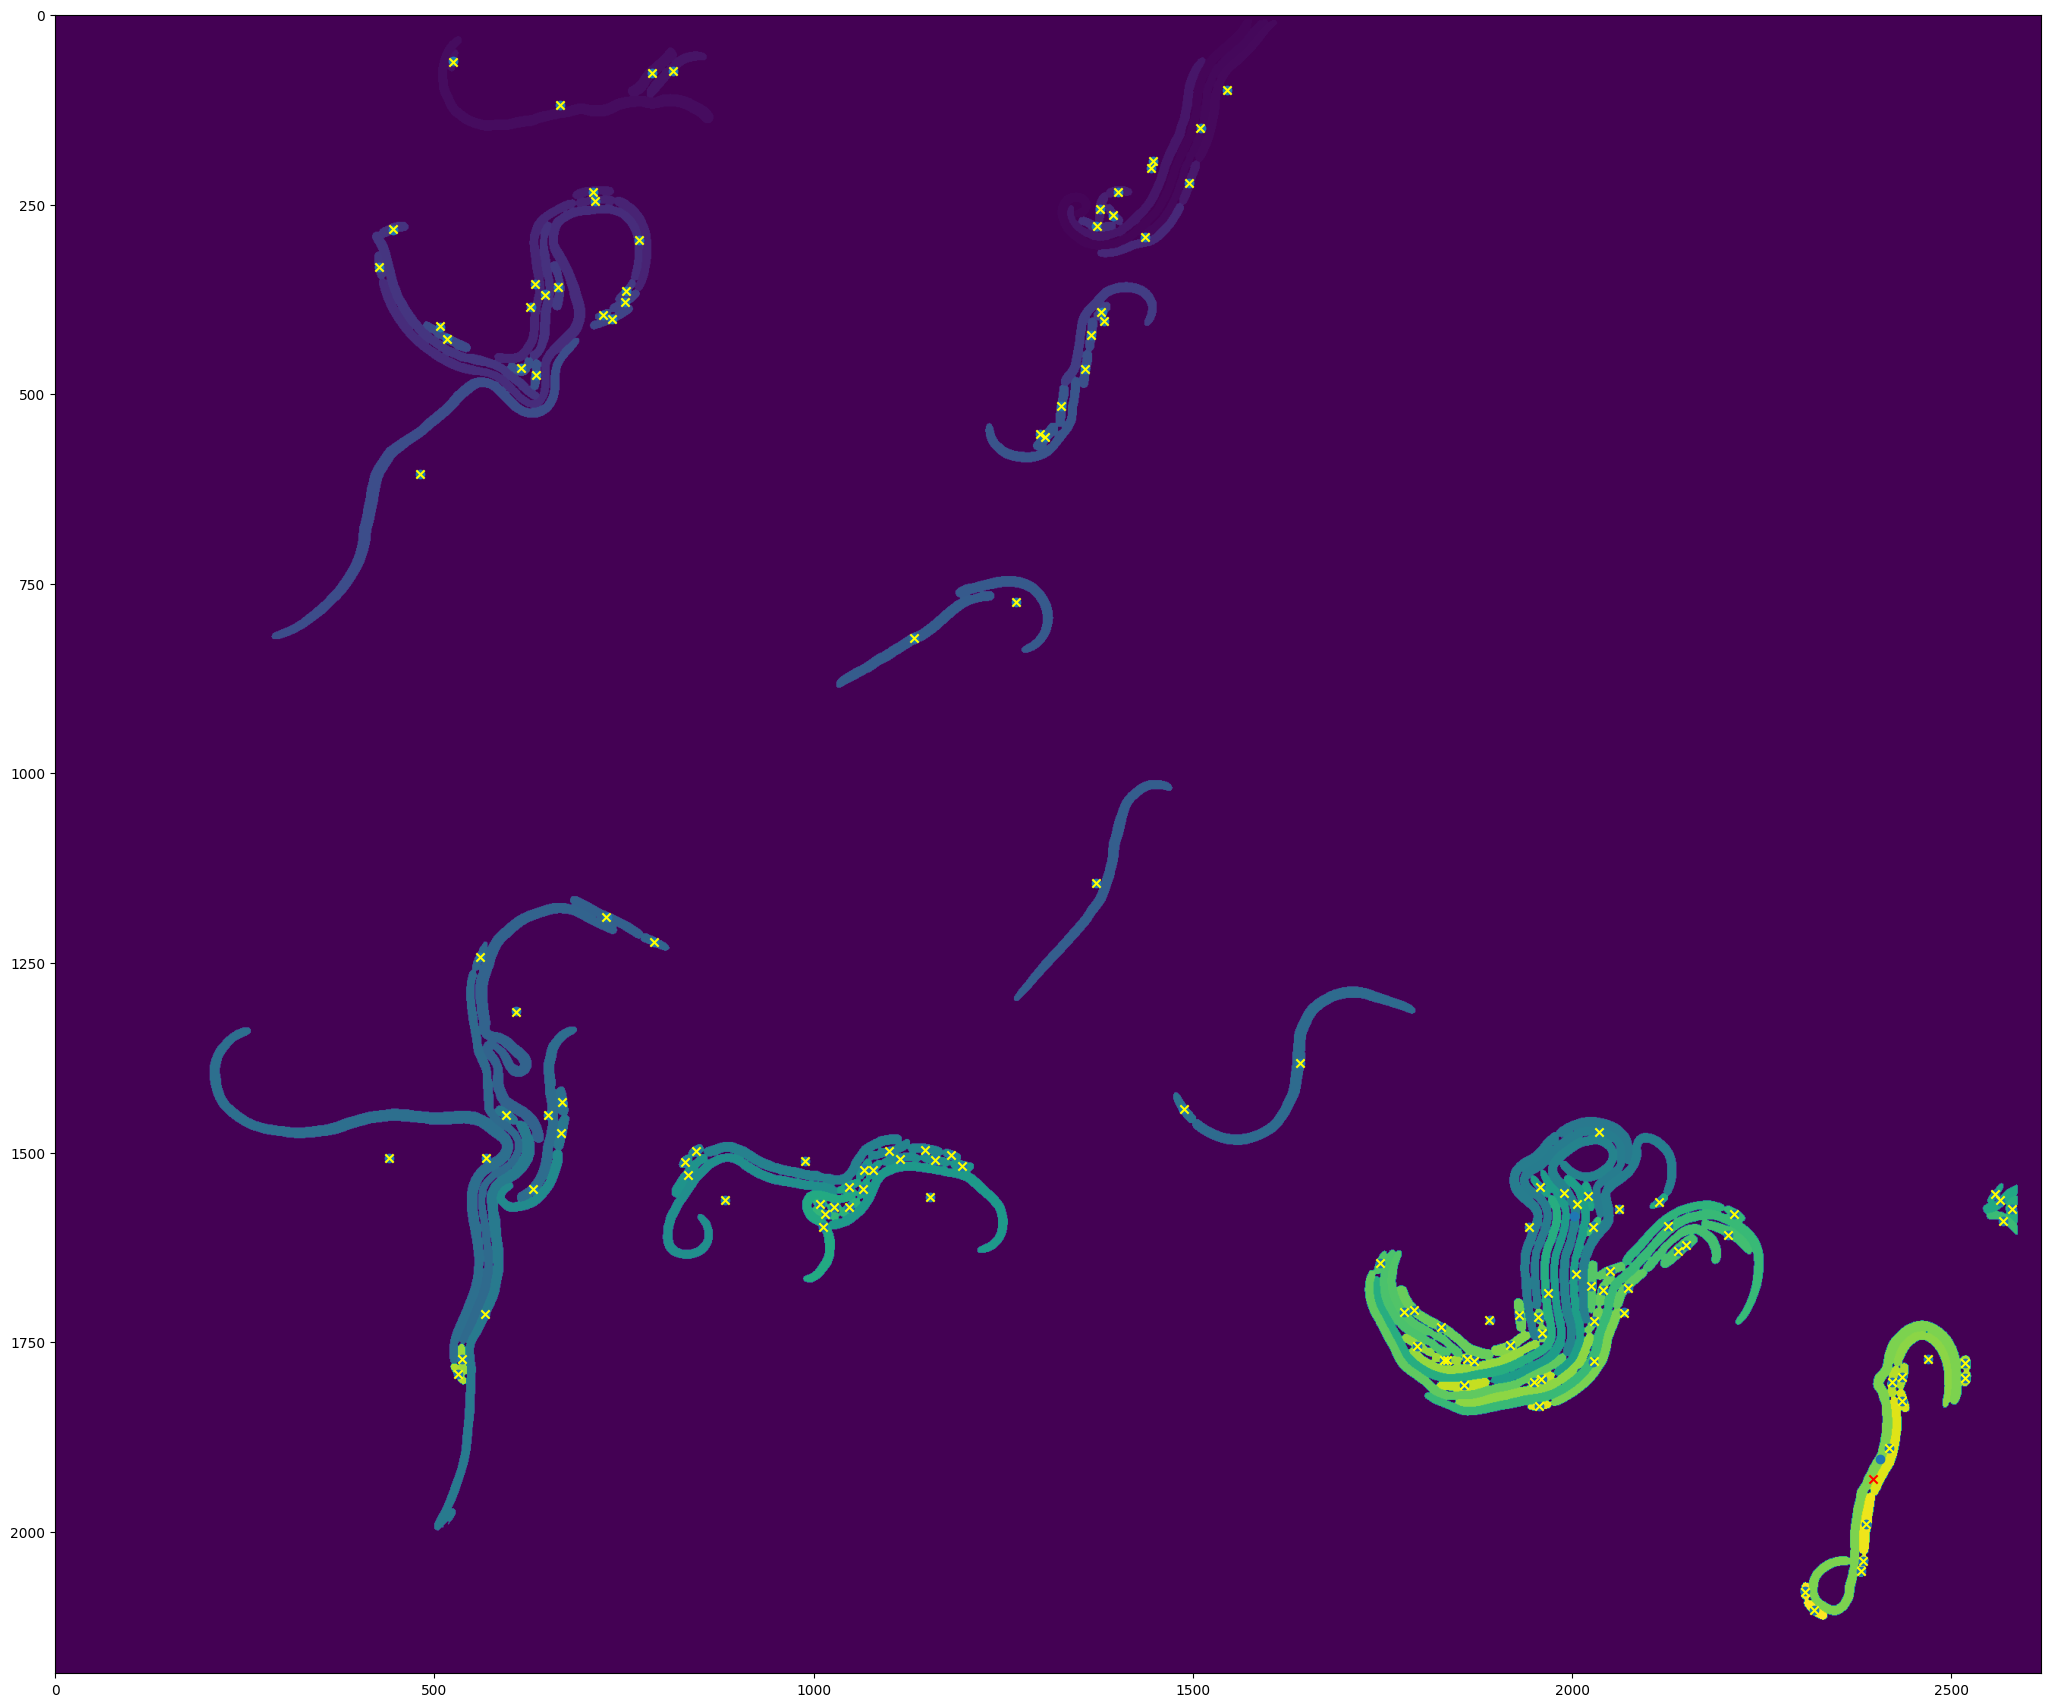

In [297]:
import matplotlib.pyplot as plt


npy_path = "/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/phase/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00029xy0c1_seg.npy"
dat = np.load(npy_path, allow_pickle=True).item()
gradientsx = np.gradient(dat['flows'][-1][0])
gradientsy = np.gradient(dat['flows'][-1][1])
gradient_total = gradientsy[1] + gradientsx[0]
regs_label = dat['masks']

#data = loadmat("/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/seg/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00028xy0_err.mat")
#regs_label = data['regs']['regs_label'][0][0]



plt.figure(figsize=(25.63, 21.87))
image = plt.imshow(regs_label)

spot = spots[spots[time]==row[time]]

plt.scatter(df['x_mean'], df['y_mean'])
plt.scatter(spot[x_position] * 100, spot[y_position] * 100, color='yellow', marker='x', label='Marked Points')
#plt.scatter(row[x_position] * 100 , row[y_position] * 100, color='red', marker='x', label='Marked Points')
plt.scatter( trackmate_x  ,  trackmate_y, color='red', marker='x', label='Marked Points')

#plt.scatter(cell['x_mean'], cell['y_mean'], color='red', marker='x', label='Marked Points')


In [9]:
from PIL import Image
import numpy as np

data = np.array(regs_label,  dtype=np.int32)
image = Image.fromarray(data, 'I')

# Save the image as a file
image.save('output.png')

In [208]:
data = loadmat('/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/seg/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00004xy0_err.mat')
label = data['regs']['regs_label'][0][0]

In [209]:
npy_path = "/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/phase/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00004xy0c1_seg.npy"
dat = np.load(npy_path, allow_pickle=True).item()
regs_label = dat['masks']

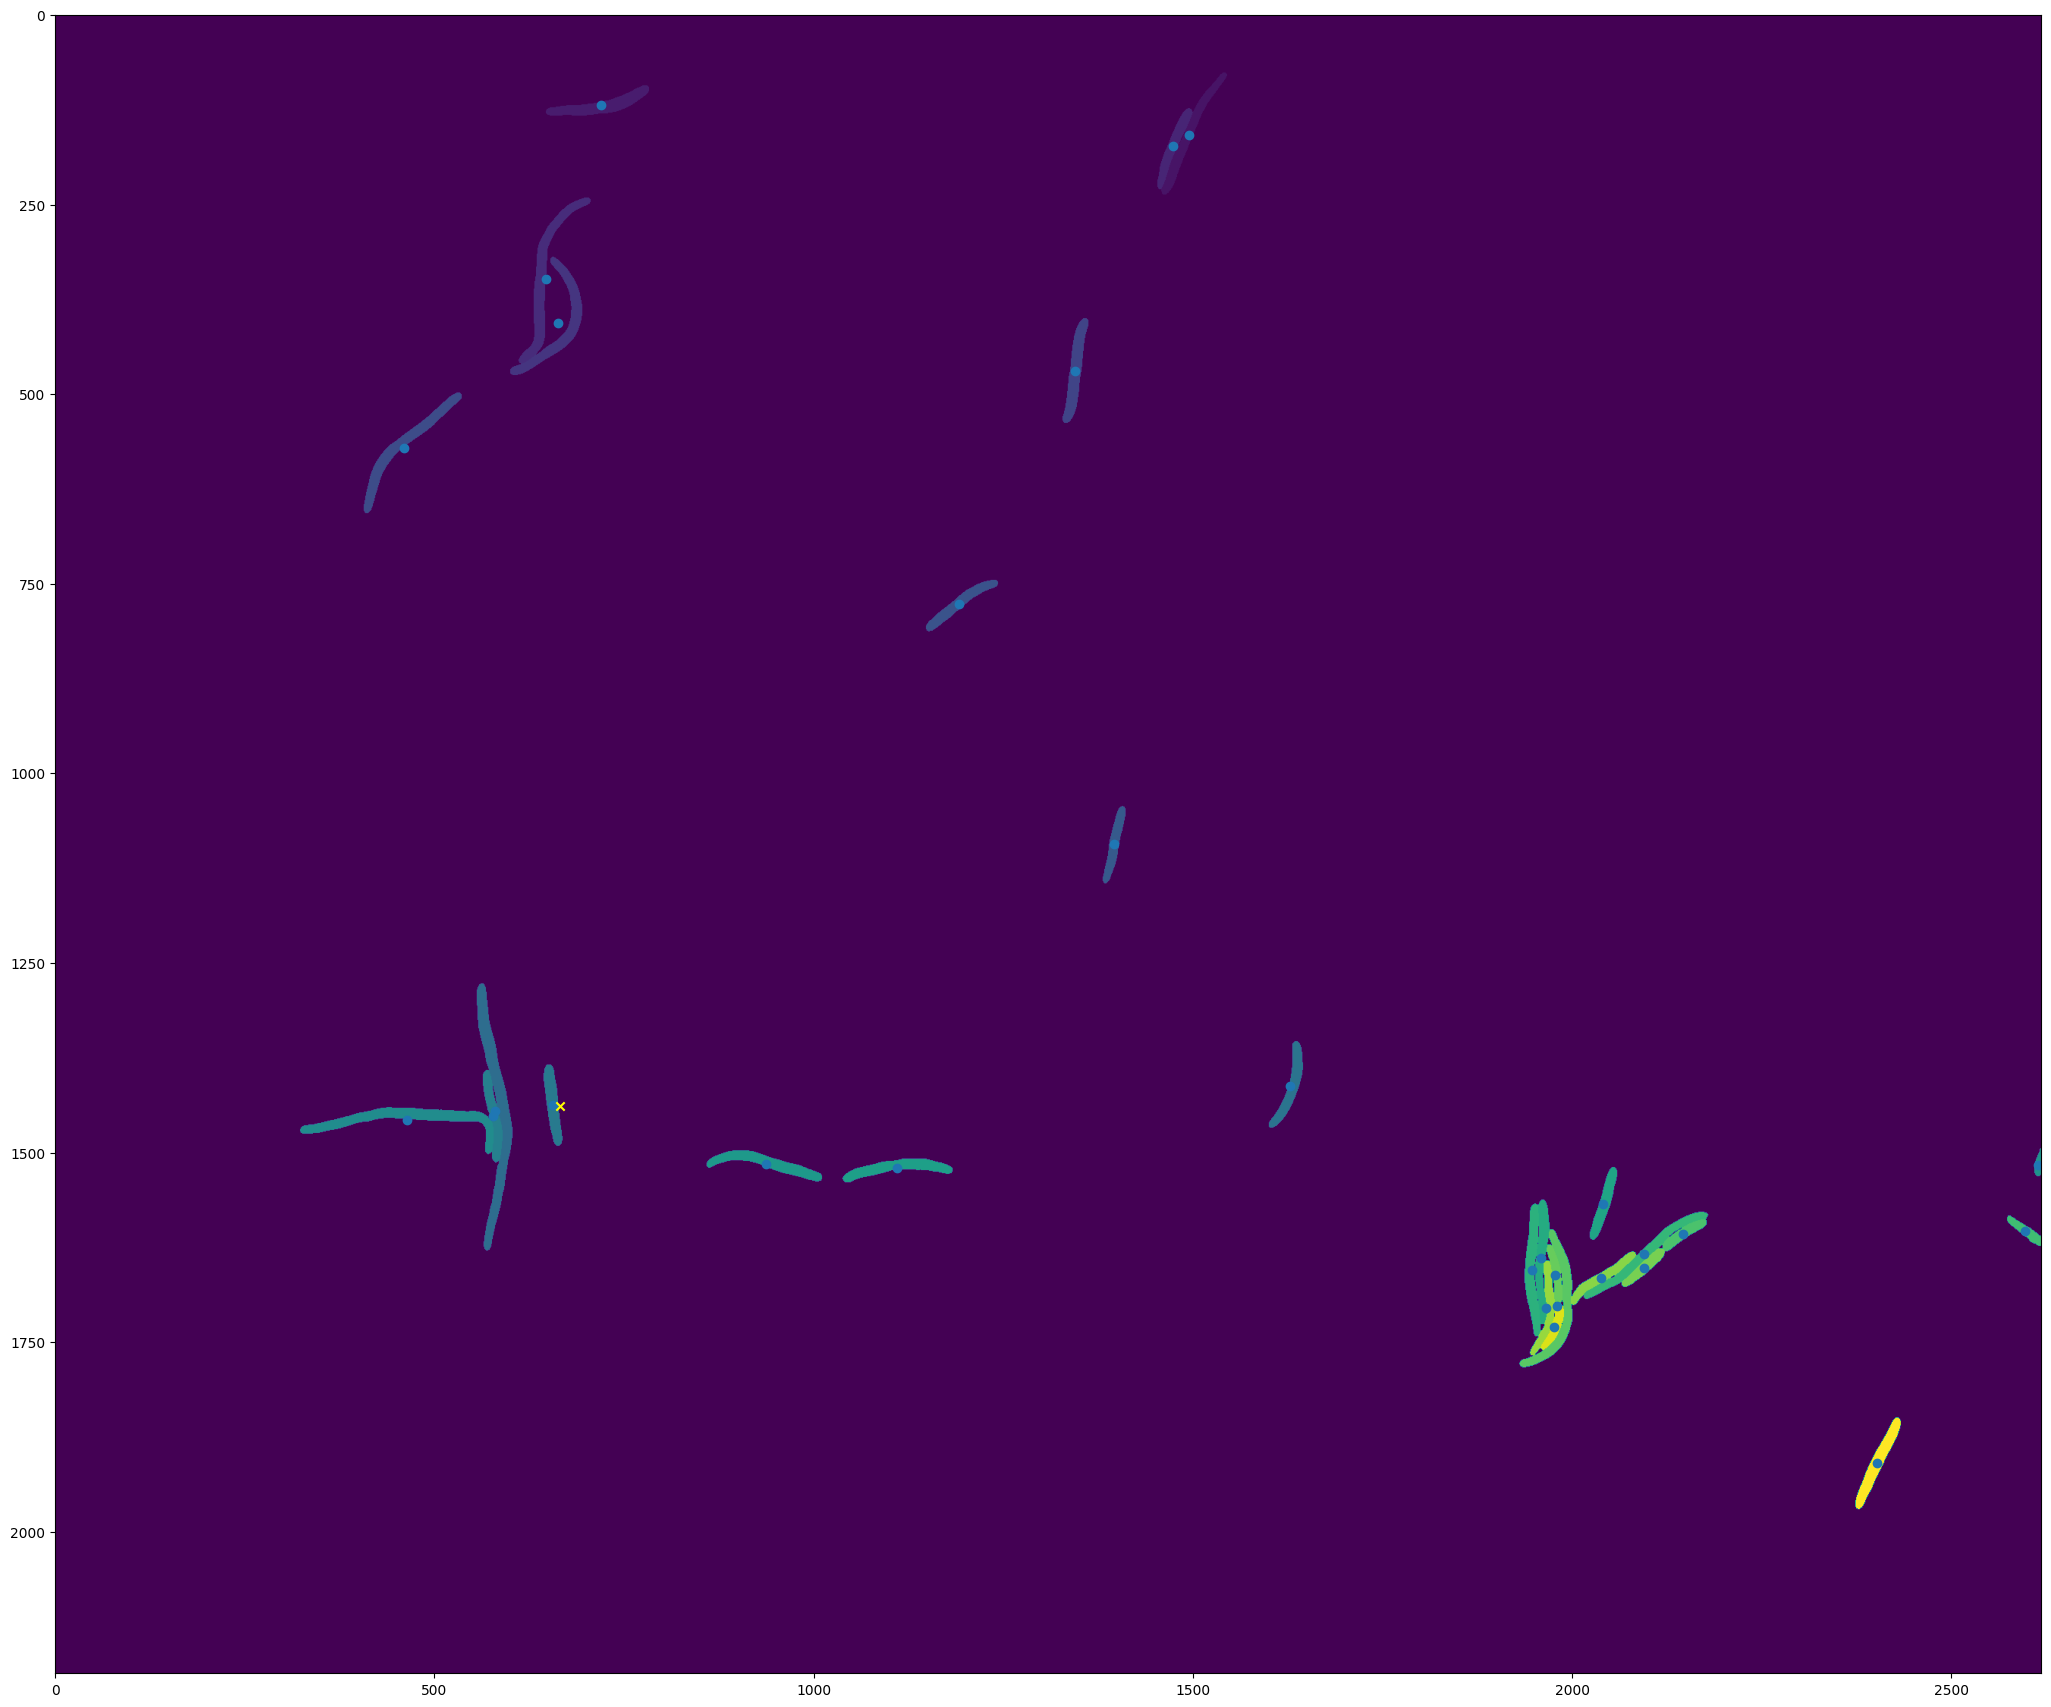

In [211]:
plt.figure(figsize=(25.63, 21.87))
plt.imshow(regs_label)

#plt.scatter(target_frame__df['x_mean'], target_frame__df['y_mean'])
plt.scatter(ground_reference_df['x_mean'], ground_reference_df['y_mean'])
plt.scatter(cell['x_mean'], cell['y_mean'], color='yellow', marker='x', label='Marked Points')

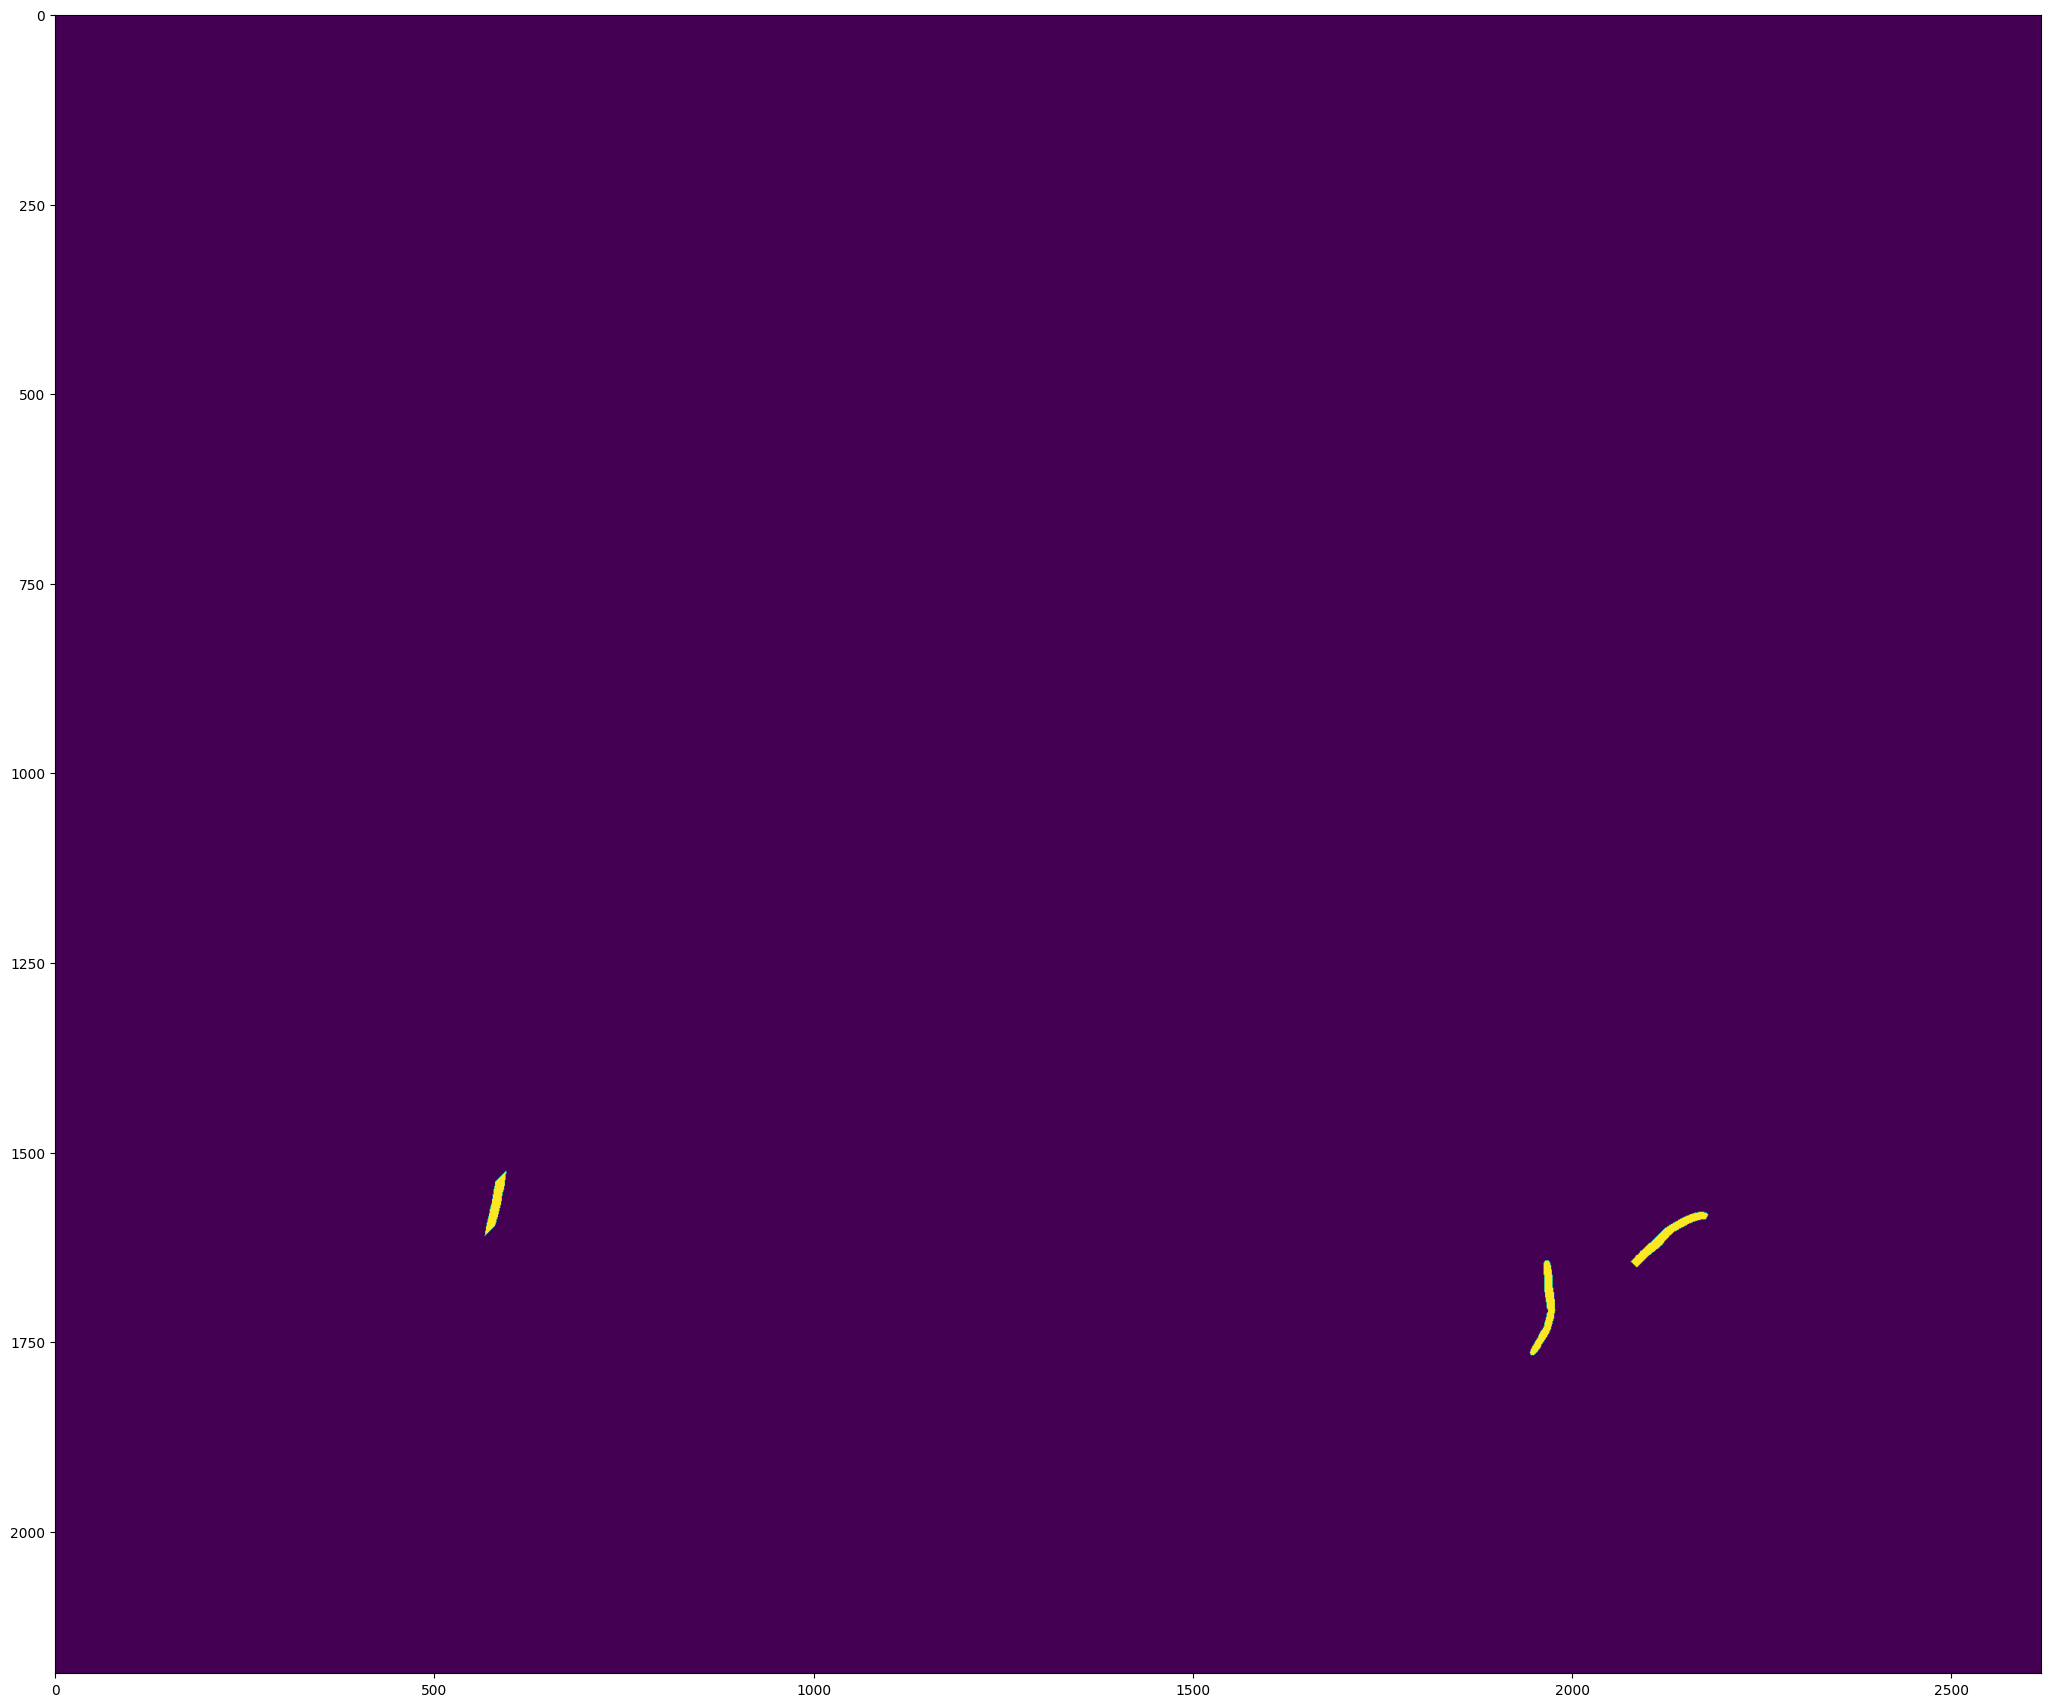

In [219]:
plt.figure(figsize=(25.63, 21.87))
plt.imshow(label == 41)